In [197]:
library(CausalImpact)
library(zoo)

## (3 балла) Изучите модель, используемую в качестве дефолтной в CausalImpact. Объясните «на пальцах» о том, как работает дефолтная модель, и сделайте выводы о границах её применимости.

![model](model.png)

Таргет $y_t$ моделируется, как некое латентное состояние плюс белый шум.  
Латентное состояние включает в себя локальный уровень $\mu_t$, локальный линейный тренд $\delta_t$ и множество переменных предиктора $x_t$, домноженных на коофиценты регресии $\beta_{\rho}$. Локальный линейный тренд изменяется под воздействием случайного блуждания по нормальному распределению с центром в предыдущей точке и фиксированной дисперсией $\sigma_{\delta}^2$. Локальный уровень - аналогично с прибавкой из тренда и своей дисперсией $\sigma_{\mu}^2$. Коофиценты для регресии $\beta_{\rho}$ также получаются из случайного блуждания с фиксированной дисперсией по каждой размерности.  
Суммируя локальный уровень и предикторы, домноженные на коофиценты регресии, получаем латентное состояние для распределения $y_t$.  
Таким образом, можем получить распределение для величин $y_{n+1} \dots y_m$, вычитая которые из реальных данных после события, можем пронаблюдать вероятность causal impact.  
Модель довольно гибкая и способна при дополнительных слагаемых вобрать в себя эффекты от тренда, сезонности, особых событий.

## (3 балла + бонусные баллы за редкие и хорошие примеры) У модели, используемой в CausalImpact, есть множество различных дополнительных параметров (параметры сезонности, динамические параметры модели). Проведите эксперименты с различными данными и на их основе создайте список эмпирических правил, когда использование дополнительных параметров позволит улучшить результат, а когда, несмотря на их кажущуюся «логичность», их использование портит результат. Постарайтесь в этих правилах рассмотреть максимальное число ситуаций "с подвохом", когда человек, не проделавший данное упражнение, скорее попытался бы воспользоваться неудачными параметрами. Все правила проиллюстрируйте примерами, и желательно чтобы данные в примерах были "правдоподобными".

Сезонность, очевидно, может помочь при сезонности в данных.  
Динамические коэффициенты могут помочь, когда линейная зависимость между метриками и данными изменяется со временем.

In [17]:
set.seed(239)

In [125]:
genCIevent <- function(order = c(1,0,1), ar = 0.999, ma = 0.999, sd = 1) {
    x1 <- 100 + arima.sim(model = list(ar = ar, ma = ma, order = order), n = 100, sd = sd)
    y <- 1.2 * x1 + rnorm(100)
    y[71:100] <- y[71:100] + 10
    data <- cbind(y, x1)
    pre.period <- c(1, 70)
    post.period <- c(71, 100)
    result = list(data=data, pre.period=pre.period, post.period=post.period)
    return(result)
}

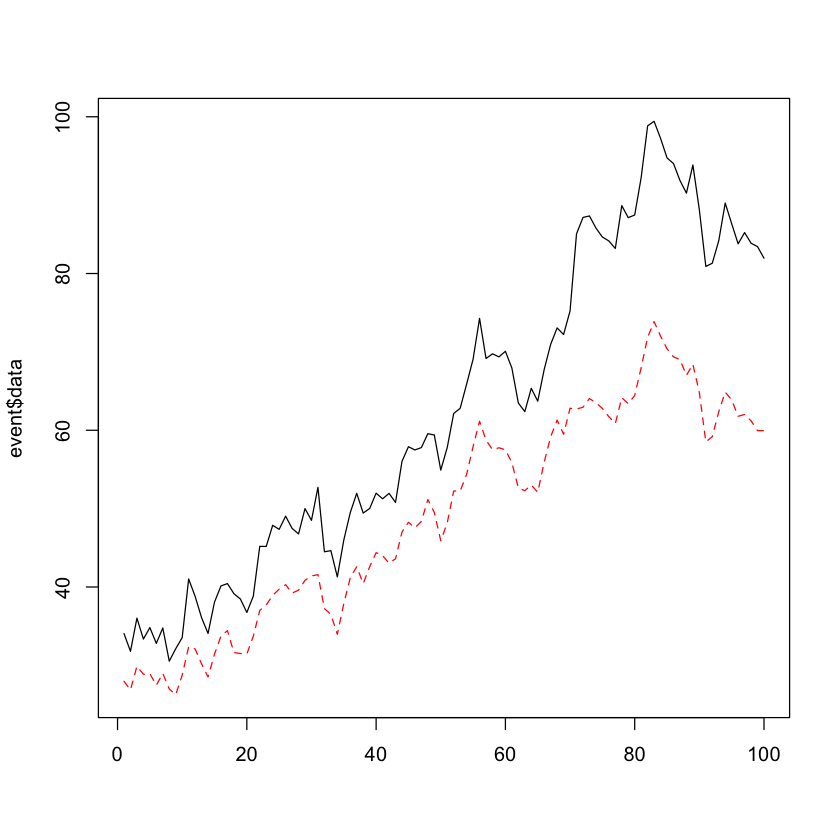

In [145]:
event <- genCIevent(ma = 0.2, sd = 2)
matplot(event$data, type = "l")

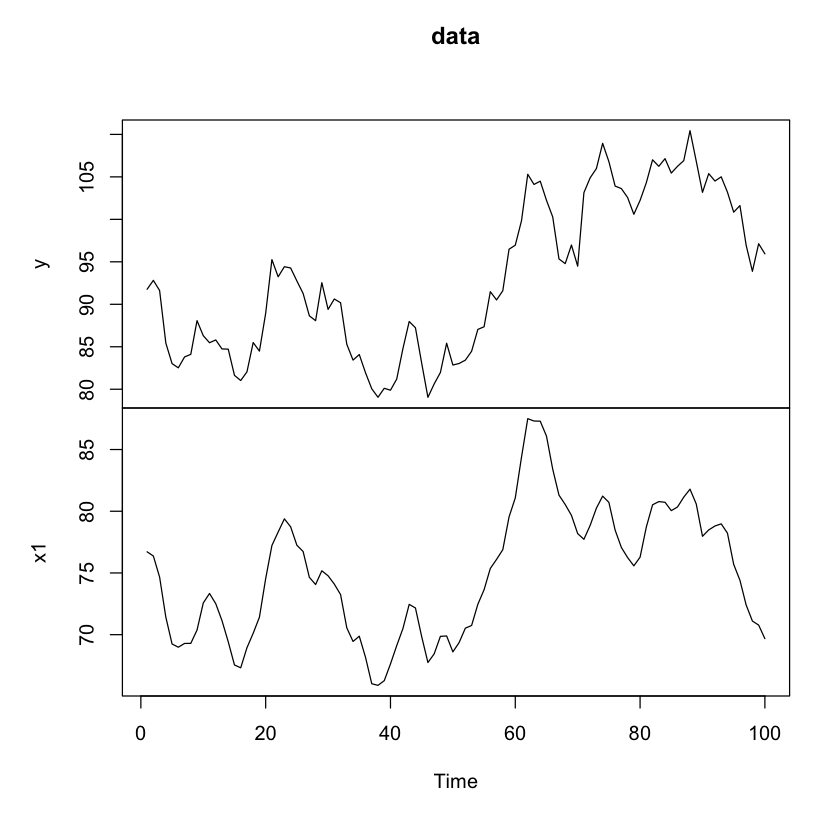

In [16]:
plot(data)

,Actual,Pred,Pred.lower,Pred.upper,Pred.sd,AbsEffect,AbsEffect.lower,AbsEffect.upper,AbsEffect.sd,RelEffect,RelEffect.lower,RelEffect.upper,RelEffect.sd,alpha,p
Average,117.0485,106.5236,105.8028,107.2382,0.369645,10.52491,9.810345,11.24572,0.369645,0.09880352,0.0920955,0.1055703,0.003470075,0.05,0.001
Cumulative,3511.4555,3195.7083,3174.0838,3217.1452,11.089349,315.74722,294.310343,337.37173,11.089349,0.09880352,0.0920955,0.1055703,0.003470075,0.05,0.001


Warning message:
“Removed 100 rows containing missing values (geom_path).”Warning message:
“Removed 200 rows containing missing values (geom_path).”

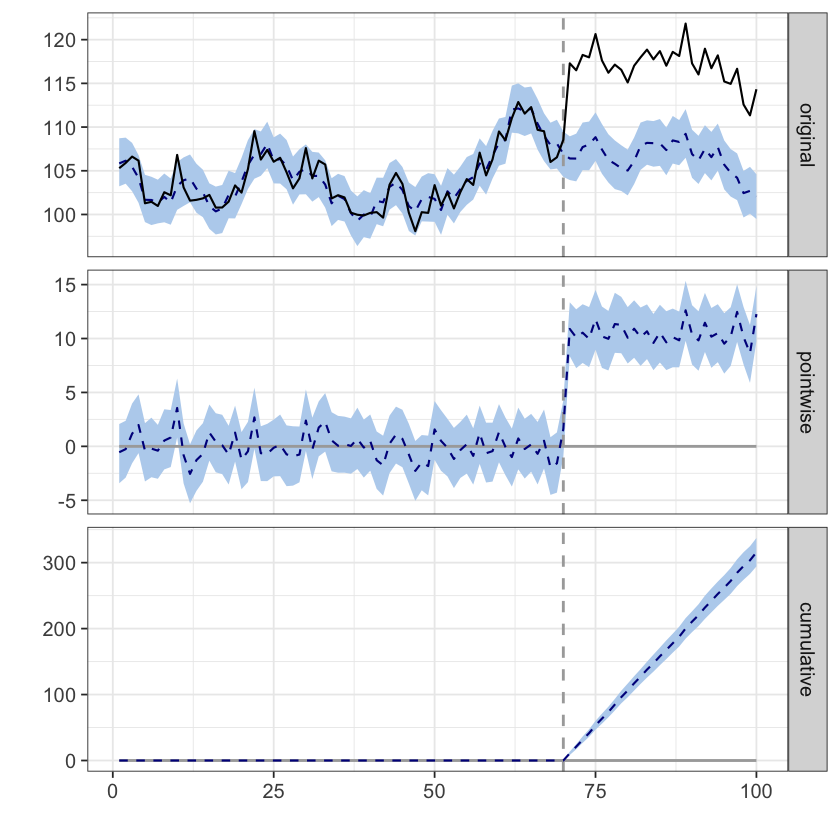

In [13]:
impact <- CausalImpact(data, pre.period, post.period, model.args = list())
impact$summary
plot(impact)

,Actual,Pred,Pred.lower,Pred.upper,Pred.sd,AbsEffect,AbsEffect.lower,AbsEffect.upper,AbsEffect.sd,RelEffect,RelEffect.lower,RelEffect.upper,RelEffect.sd,alpha,p
Average,117.0485,106.5735,105.8884,107.2772,0.3610424,10.47504,9.771289,11.16009,0.3610424,0.09828933,0.09168593,0.1047173,0.003387732,0.05,0.001
Cumulative,3511.4555,3197.2044,3176.6528,3218.3168,10.8312708,314.25108,293.138662,334.80273,10.8312708,0.09828933,0.09168593,0.1047173,0.003387732,0.05,0.001


Warning message:
“Removed 100 rows containing missing values (geom_path).”Warning message:
“Removed 200 rows containing missing values (geom_path).”

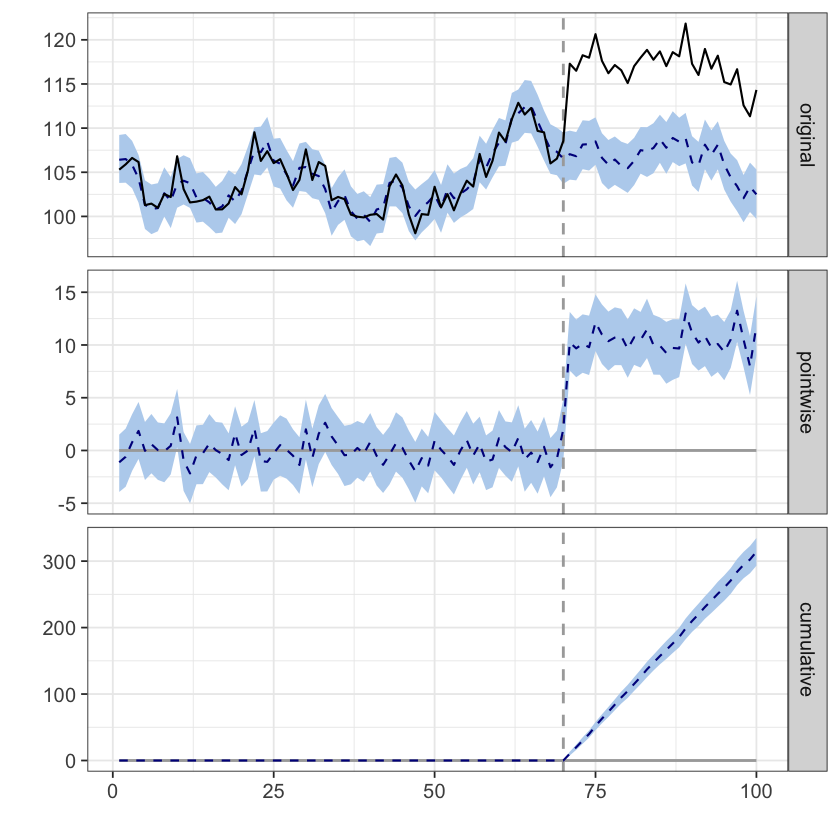

In [14]:
impact <- CausalImpact(data, pre.period, post.period, model.args = list(nseasons = 7))
impact$summary
plot(impact)

## (3 балла) Допустим несколько месяцев назад Яндекс значительно улучшил качество поиска картинок. Вы хотите узнать увеличило ли это изменение активность пользователей на основном поиске Яндекса. Какими рядом-таргетом и рядом-предиктором вы бы воспользовались? Обоснуйте свой ответ, а также укажите возможные проблемы вашего решения и как бы вы их обошли.

Требования к ряду-предиктору следующие: необходимо, чтобы по предиктору мы могли хорошо предсказывать таргет до события, а также влияние события на предиктор должно быть минимально.  
При поиске текста Яндекс может предлагать related картинки и видео. Улучшение качества поиска картинок должно увеличить количество переходов с текста на картинки, а также, непосредственно, количество картинок, которые пользователь захотел рассмотреть поближе. Среднее количество таких событий за день/час можно взять в качестве временного ряда-таргета. Такой ряд сможет показать изменение активности пользователей.  
Для предиктора же подойдет, например, количество переходов в related видео или другие источники (учитывая, что качество их поиска не изменилось). Количество переходов и поиска на картинки и на видео должно коррелировать, учитывая, что пользователь ищет некую визуальную информацию.  
Возможные проблемы:
* Надо точно отследить, чтобы в окрестности события - улучшения качества поиска картинок - не было других событий, влияющих на ряд-предиктор.

## (10 баллов) Представьте, что у Яндекса есть ещё один сервис – Яндекс.Котики. Вам нужно оценить эффективности рекламных кампаний, шедших в период с августа по ноябрь (включительно) 2015 года (для каждой отдельная оценка). У этой задачи может быть много способов её решения, ваша цель достигнуть максимально точной и корректной итоговой оценки. [В первом файле](https://wiki.school.yandex.ru/shad/groups/2016/Semester3/Analytical/.files/causalimpacthomeworkdata1.csv) вы можете найти информацию об аудитории данного сервиса (target), различные оценки аудитории, интересующейся котиками (market), а так же показатели различных срезов аудитории сервиса, которые могли быть или не быть подвержены воздействию рекламных кампаний. [Во втором файле](https://wiki.school.yandex.ru/shad/groups/2016/Semester3/Analytical/.files/causalimpacthomeworkdata2.csv) вы найдете информацию о датах рекламных кампаний и оценку (возможно неверную) их размеров. В этом же файле есть информация и о рекламных кампаниях некоторых других сервисов, которые потенциально могли воздействовать на Яндекс.Котиков (например, реклама с посылом "весь Яндекс - это круто" могла помочь нашему сервису, а могла и не повлиять на его популярность).

Начнем.  
Считаем данные. Распарсим, где получится, числа, а также - даты. 

In [621]:
data1 <- read.csv("CausalImpact_homework_data1.csv")
data2 <- read.csv("CausalImpact_homework_data2.csv")

In [622]:
options(warn=-1)

# data1
data1[,c(2:ncol(data1))] <- lapply(data1[,c(2:ncol(data1))], function(x) as.numeric(as.character(x)))
data1 <- na.locf(data1)
data1[,c(2:ncol(data1))] <- lapply(data1[,c(2:ncol(data1))], as.numeric)
                                   
# data2
data2[,c(3:ncol(data2))] <- lapply(data2[,c(3:ncol(data2))], function(x) as.numeric(as.character(x)))
data2 <- na.locf(data2)
data2[,c(3:ncol(data2))] <- lapply(data2[,c(3:ncol(data2))], as.numeric)

options(warn=0)

In [623]:
origin <- as.Date(data1["date"][1,])
last.day <- as.Date(data1["date"][nrow(data1),])
data1$date <- seq.Date(origin, by = 1, length.out = nrow(data1))
data2["start_date"] <- lapply(data2["start_date"], function(days) as.Date(days - 1, origin = origin))
data2["end_date"] <- lapply(data2["end_date"], function(days) as.Date(days - 1, origin = origin))

Проверяем, есть ли NA-шки.

In [624]:
c(anyNA(data1), anyNA(data2))

[1] FALSE FALSE

In [625]:
data1[c(1:4),]

date,target,market_1,market_2,market_3,market_4,market_5,should_be_impacted_1,should_be_impacted_2,should_be_impacted_3,⋯,may_be_not_impacted_3,may_be_not_impacted_4,may_be_not_impacted_5,may_be_not_impacted_6,may_be_not_impacted_7,may_be_not_impacted_8,may_be_not_impacted_9,may_be_not_impacted_10,may_be_not_impacted_11,may_be_not_impacted_12
2013-12-18,21110.60,5855898,10490066,6400020,17303909,8277376,202418.0,501304.0,281527.7,⋯,2.46,20.30,11.76,13.53,27.36,23.53,41.25,0.00,23.73,9.24
2013-12-19,19985.20,5233946,8856544,5772768,13711773,7417712,195205.4,456269.5,222715.5,⋯,2.05,13.05,12.25,14.76,28.50,28.96,37.95,11.94,31.64,6.93
2013-12-20,19602.36,4923801,8346250,5429014,12574661,6999351,205468.9,496172.0,283458.8,⋯,1.23,23.20,10.78,9.84,45.03,27.15,34.65,7.96,28.25,3.85
2013-12-21,21955.16,6061035,10408902,6624329,17318726,8561364,210051.0,516636.4,272849.0,⋯,3.28,24.65,10.78,11.07,44.46,25.34,36.30,5.97,38.42,8.47


In [626]:
data2[c(1:4),]

num,start_date,end_date,estimation_size_of_marketing_activity,is_related_to_our_service
1,2014-01-12,2014-02-11,4.6,1
2,2014-01-17,2014-02-15,0.1,0
3,2014-02-07,2014-02-21,0.5,1
4,2014-04-07,2014-05-10,5.7,1


Получим список событий снутри промежутка август15 - ноябрь15.

In [627]:
observe.start <- as.Date("2015-08-01")
observe.end <- as.Date("2015-11-30")
observe.main_event <- list(start_date = observe.start, end_date = observe.end)
observe.events <- data2[which(data2$start_date >= start.observe & data2$end_date <= observe.end),]
observe.events

,num,start_date,end_date,estimation_size_of_marketing_activity,is_related_to_our_service
25,25,2015-09-01,2015-09-15,1.5,1
26,26,2015-09-01,2015-10-16,0.1,1
27,27,2015-09-08,2015-10-16,0.0,0
28,28,2015-09-11,2015-09-22,0.7,0
29,29,2015-09-29,2015-10-15,0.4,0
31,31,2015-11-11,2015-11-24,0.0,1


In [628]:
target <- data1$target

cor.prs <- function(target, predictor) {
    res <- cor.test(target, predictor, method = "pearson", use = "complete.obs")
    return(list(cor = as.numeric(res$estimate), p.value = res$p.value))
}

check <- function (predictor, event) {
    date.before <- data1$date < event$start_date
    date.inside <- data1$date >= event$start_date & data1$date <= event$end_date
    date.after <- data1$date > event$end_date
    
    before <- cor.prs(target[date.before], predictor[date.before])
    inside <- cor.prs(target[date.inside], predictor[date.inside])
    after <- cor.prs(target[date.after], predictor[date.after])
    
    return(list(before = before, inside = inside, after = after))
}

In [629]:
predictors <- c("market_1", "market_2", "market_3", "market_4", "market_5")

In [630]:
befores <- list()
insides <- list()
afters <- list()

for (predictor in predictors){
    test <- check(unlist(data1[predictor]), observe.main_event)
    befores <- c(befores, test$before$cor)
    insides <- c(insides, test$inside$cor)
    afters <- c(afters, test$after$cor)
}

In [631]:
rbind(befores, insides, afters)

befores,0.9344335,0.8992521,0.8228765,0.9569206,0.9350295
insides,0.3415518,0.165048,0.2173323,0.8803169,0.4051838
afters,0.5452291,0.8236455,0.8048995,0.7736828,0.791723


Нам интересны события, которые нарушают корреляцию таргета и предиктора. Возьмем большое событие с август15 по ноябрь15 и посмотрим, как ведет себя корреляция Пирсона для рядов до, внутри и после события.  
Как можно видеть, до периода рекламы все придикторы хорошо коррелируют с таргетом, во время - только 4ый, а после - все, кроме 1го. Таким образом, будем рассматривать 2, 3 и 5 столбцы-предикторы.  
Запустим CI для каждой пары интересное событие / предиктор и заполним таблицу.

In [640]:
# predictors <- c("market_2", "market_3", "market_5")
predictors <- c("market_5")

In [645]:
for (i in 1:nrow(observe.events)) {
    event <- observe.events[i,]
    for (predictor in predictors) {
        data <- zoo(cbind(target, data1[predictor]), data1$date)
        pre.period <- as.Date(c(origin, event$start_date - 1))
        post.period <- as.Date(c(event$start_date, event$end_date))
        impact <- CausalImpact(data, pre.period, post.period)
        # summary(impact)
    }
}

| Рекламная компания (num) | size/is related | market_2  | market_3  | market_5  |
|:------------------------:|-----------------|-----------|-----------|-----------|
|            25            | 1.5 / 1         | 0.01 98%  | 0.01 98%  | 0.02 97%  |
|            26            | 0.1 / 1         | 0.001 99% | 0.001 99% | 0.001 99% |
|            27            | 0.0 / 0         | 0.001 99% | 0.001 99% | 0.001 99% |
|            28            | 0.7 / 0         | 0.04 95%  | 0.04 96%  | 0.06 94%  |
|            29            | 0.4 / 0         | 0.06 93%  | 0.04 95%  | 0.03 96%  |
|            31            | 0.0 / 1         | 0.04 99%  | 0.01 99%  | 0.01 99%  |

Таким образом, лучший результат наблюдается у реклам под номерами 26, 27 и 31.